## Gain over strawmen / impact of memory size
### dataset
### algo

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json

from result_plots.QuerySketch.common.common import get_metric_mapping # read_data
from result_plots.QuerySketch.common.process_data_from_solver import get_mean_from_iterations, normalize_error_result, get_ensemble_error
from result_plots.QuerySketch.common.plot import get_x_position, get_xtick_position, \
                                                get_gain, gain_over_strawman # get_result_from_pkl plot_raw, consolidate_gain_over_strawman

In [2]:
def read_data(algos=['cs'], row=5, width=4096, level=1, seed=1, count=1, flowkey='dstIP,dstPort', 
              epochs=['30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    for algo in algos:
        res[algo] = []
        for epoch in epochs:
            path = f"../../result_smartnic_cp/QuerySketch/{algo}/{dataset}"\
                    f"{flowkey}/row_{row}_width_{width}_level_{level}_epoch_{epoch}_count_{count}_seed_{seed}/data.pkl"
            # print(algo, epoch)
            with open(path, 'rb') as f:
                ll = pickle.load(f)
            res[algo].append(ll)
            # print(ll[0])
    return res

In [3]:
def get_result_from_pkl(algos = ['cm'], rows = [1, 2, 3, 4, 5], widths = [4096, 8192, 16384, 32768, 65536, 131072], level=1, seeds=[1, 2, 3], 
                           count=1, measure_list = ['hh', 'entropy'], flowkeys = ["dstIP,dstPort",], epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
    
    mapping = get_metric_mapping()
    
    # key: seed, metric, row, width
    total_ret = {}
    for seed in seeds:
        total_ret[seed] = {}
        for m in measure_list:
            total_ret[seed][m] = {}
            for r in rows:
                total_ret[seed][m][r] = {}
                for w in widths:
                    total_ret[seed][m][r][w] = []

    for seed in seeds:
        for r in rows:
            for w in widths:
                for flowkey in flowkeys:
                    for dataset in datasets:
                        tmp = read_data(algos, r, w, level, seed, count, flowkey, epochs, dataset)
                        for algo in algos:
                            for measure in measure_list:
                                # epoch
                                for e in range(len(epochs)):
                                    # raw data
                                    # for d in tmp[algo][e]:
                                    d = tmp[algo][e]
                                    # print(tmp[algo][e])
                                    # print(d[mapping[algo][measure]])
                                        # total_ret[seed][measure][r][w].append(d[mapping[algo][measure]])
                                    total_ret[seed][measure][r][w].append(d[mapping[algo][measure]])
                                    # print(w, flowkey, measure, epochs[e], np.mean(ll))
    # print(total_ret)
    # get mean/median from all seed results
    # key: metric, row, width
    final_ret = {}                                
    for m in measure_list:
        final_ret[m] = {}
        for r in rows:
            final_ret[m][r] = {}
            for w in widths:
                final_ret[m][r][w] = []
    
    for m in measure_list:
        for r in rows:
            for w in widths:
                arr = None
                for seed in seeds:
                    if arr is None:
                        arr = total_ret[seed][m][r][w]
                    else:
                        arr = np.vstack([arr, total_ret[seed][m][r][w]])
                final_ret[m][r][w] = [np.mean(arr, axis=0).tolist()]
                # print(f'm: {m} r: {r} w: {w}, {final_ret[m][r][w]}')
    # print(len(final_ret[m][r][w]))
    # print(final_ret)
    return final_ret

---

## Plotting functions

In [4]:
## Plot raw result
def plot_raw(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, \
             name, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    ## comparison version plot
    # box plot 
    # https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
    # Box plots with custom fill colors
    # https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

    import matplotlib.patches as mpatches
    
    metric_to_label = {}
    metric_to_label['hh'] = 'H'
    metric_to_label['entropy'] = 'E'
    metric_to_label['card'] = 'C'
    metric_to_label['fsd'] = 'F'
    metric_to_label['change_det'] = 'D'

    xlabels = []
    for m in all_metrics:
        xlabels.append(metric_to_label[m])
    
    colors = ['deeppink', 'darkred', 'royalblue', 'darkblue', 'darkgreen']
    colors = colors * len(xlabels)

    fig = plt.figure(figsize = (10, 6))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    plot_list = []
    for m in all_metrics:
        plot_list.append(ret_sol1[m][0])
        plot_list.append(ret_sol2[m][0])
        plot_list.append(ret_sol3[m][0])
        plot_list.append(ret_sol4[m][0])
        plot_list.append(ret_us[m][0])

    x_list = np.arange(0, len(plot_list), 1, dtype=int)
    # Creating plot
    # bplot = ax.boxplot(x=plot_list, 
    #                    positions = get_x_position(len(all_metrics), 5),
    #                    patch_artist=True)
    bplot = ax.bar(x_list, plot_list, color=colors)
    # ax.set_xlim(0, 1)
    # ax.set_ylim([0, 105])

    # for patch, color in zip(bplot['boxes'], colors):
    #     patch.set_facecolor(color)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.ylabel("Error (%)", fontsize=30)
    plt.xlabel("Available metrics", fontsize=30)
    plt.xticks(get_xtick_position(len(all_metrics), 5), xlabels, fontsize=26)
    plt.yticks(fontsize=26)

    # plt.title(f"Error - {name}", fontsize=18)

    # create legends
    legend_patch = []
    legend_patch.append(mpatches.Patch(color=colors[0], label='Random-Uniform'))
    legend_patch.append(mpatches.Patch(color=colors[1], label='Random-Proportional'))
    legend_patch.append(mpatches.Patch(color=colors[2], label='Lazy-Uniform'))
    legend_patch.append(mpatches.Patch(color=colors[3], label='Lazy-Proportional'))
    legend_patch.append(mpatches.Patch(color=colors[4], label='Bruteforce'))
    plt.legend(handles=legend_patch, fontsize=14) # , loc="upper right"

    # import pickle
    # with open(f'pickles/{name}.pkl', 'wb') as fout:
    #     pickle.dump(fig, fout)
    # plt.savefig(f'figures/individual_metric/{name}.png', format='png', bbox_inches='tight')
    # plt.savefig('test.eps', format='eps', bbox_inches='tight')

    # show plot
    plt.show()

In [5]:
## Consolidate all metrics with gain over result
def consolidate_gain_over_strawman(gain_result, name, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    # merge_gain_result = [[], [], [], []]
    merge_gain_result = np.zeros((4, len(gain_result[all_metrics[0]][0]))) # 4 strawman

    for m in all_metrics:
        # concatenate gains from all metrics
        # merge_gain_result[0] = np.concatenate((merge_gain_result[0], gain_result[m][0]))
        # merge_gain_result[1] = np.concatenate((merge_gain_result[1], gain_result[m][1]))
        # merge_gain_result[2] = np.concatenate((merge_gain_result[2], gain_result[m][2]))
        # merge_gain_result[3] = np.concatenate((merge_gain_result[3], gain_result[m][3]))
        # get mean gain from all metrics (measure it as an ensemble)
        merge_gain_result[0] += np.array(gain_result[m][0]) / len(all_metrics)
        merge_gain_result[1] += np.array(gain_result[m][1]) / len(all_metrics)
        merge_gain_result[2] += np.array(gain_result[m][2]) / len(all_metrics)
        merge_gain_result[3] += np.array(gain_result[m][3]) / len(all_metrics)

    # print(len(merge_gain_result[0]))
    # print(len(gain_result[m][0]))
    # print(merge_gain_result)
    
    
    ## comparison version plot
    # box plot 
    # https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
    # Box plots with custom fill colors
    # https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

    import matplotlib.patches as mpatches

    xlabels = ['set1']
    colors = ['deeppink', 'darkred', 'royalblue', 'darkblue']
    colors = colors * len(xlabels)
    
    legend_label = ['Over Random-Uniform', 'Over Random-Proportional', 'Over Lazy-Uniform', 'Over Lazy-Proportional', ]

    fig = plt.figure(figsize = (10, 6))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.set_ylim([0, 100])

    plot_list = []
    for d in merge_gain_result:
        plot_list.append(d)

    # Creating plot
    bplot = ax.boxplot(x=plot_list, 
                       positions = get_x_position(len(xlabels), len(merge_gain_result)),
                       patch_artist=True)
    # ax.set_xlim(0, 1)

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # plt.axhline(y = 0, color = 'r', linestyle = '--')
        
    plt.ylabel("Gain", fontsize=16)
    plt.xticks(get_xtick_position(len(xlabels), len(merge_gain_result)), xlabels, fontsize=16)
    plt.yticks(fontsize=14)

    # plt.title("Figure 7 - Gain over with merge metrics", fontsize=18)
    plt.title(f"Merge gain - {name}", fontsize=18)

    # create legends
    # xlabels = ['Best algorithms', "General algorithm"]
    legend_patch = []
    legend_patch.append(mpatches.Patch(color='deeppink', label=legend_label[0]))
    legend_patch.append(mpatches.Patch(color='darkred', label=legend_label[1]))
    legend_patch.append(mpatches.Patch(color='royalblue', label=legend_label[2]))
    legend_patch.append(mpatches.Patch(color='darkblue', label=legend_label[3]))
    plt.legend(handles=legend_patch, fontsize=16) # , loc="upper right"

    # plt.savefig('test.png', format='png', bbox_inches='tight')
    # plt.savefig('test.eps', format='eps', bbox_inches='tight')

    # show plot
    plt.show()
    
    return merge_gain_result

In [6]:
def call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name = "Test", \
                  mem_size = 131072, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    plot_raw(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, all_metrics, isSaveFig)
    gain_result = gain_over_strawman(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, all_metrics, isSaveFig)
    merge_gain_result = consolidate_gain_over_strawman(gain_result, name, all_metrics, isSaveFig)
    
    global global_merge_gain_all_mem
    for d in merge_gain_result:
        global_merge_gain_all_mem.append(d)

    global global_name_all_mem
    global_name_all_mem.append(name)
    
    # This is for gain per metric
    # key: mem size, metric, [4 strawman]
    global global_gain_all_mem
    global_gain_all_mem[mem_size] = gain_result
    
    global global_all_mem_size
    global_all_mem_size.append(mem_size)

## Common variables

In [7]:
seeds = [1]
count = 1

flowkeys = ["dstIP,dstPort",]
epochs = ['60']
datasets = ['3mil_131000.pcap/', ]


isSaveFig = False

all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd']

In [8]:
## Global variables
## !!, must reset every time
global_merge_gain_all_mem = []
global_name_all_mem = []

# This is gain per metric
# key: mem size, metric, [4 strawman]
global_gain_all_mem = {}
global_all_mem_size = []

## record ensemble error per box
global_ensemble_error = []

---

## Plot selection results

----

### smartnic_1

In [9]:
mem_size = 131072
name = f'Mem {int(mem_size/1024)} KB (same dataset)'

ret_sol1_ll = []
ret_sol2_ll = []
ret_sol3_ll = []
ret_sol4_ll = []
ret_us_ll = []

In [10]:

# ========== smartnic_1.json ==========

#############################
ret_us = {} 

measure_list = ['hh', 'change_det', 'fsd', ]
algos = ['cm']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_us = {**ret_us, **tmp}

measure_list = ['entropy', ]
algos = ['cs']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_us = {**ret_us, **tmp}

measure_list = ['card', ]
algos = ['univmon']
widths = [256]
rows = [2]
level = 16
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_us = {**ret_us, **tmp}

ret_us_ll.append(ret_us)

#############################
ret_sol1 = {} 

measure_list = ['hh', 'fsd', ]
algos = ['cm']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol1 = {**ret_sol1, **tmp}

measure_list = ['change_det', ]
algos = ['cs']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol1 = {**ret_sol1, **tmp}

measure_list = ['entropy', 'card', ]
algos = ['univmon']
widths = [256]
rows = [2]
level = 16
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol1 = {**ret_sol1, **tmp}

ret_sol1_ll.append(ret_sol1)

#############################
ret_sol2 = {} 

measure_list = ['hh', 'fsd', ]
algos = ['cm']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol2 = {**ret_sol2, **tmp}

measure_list = ['change_det', ]
algos = ['cs']
widths = [2048]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol2 = {**ret_sol2, **tmp}

measure_list = ['entropy', 'card', ]
algos = ['univmon']
widths = [256]
rows = [2]
level = 16
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol2 = {**ret_sol2, **tmp}

ret_sol2_ll.append(ret_sol2)

#############################
ret_sol3 = {} 

measure_list = ['hh', 'entropy', 'card', ]
algos = ['univmon']
widths = [256]
rows = [2]
level = 16
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol3 = {**ret_sol3, **tmp}

measure_list = ['fsd', ]
algos = ['cs']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol3 = {**ret_sol3, **tmp}

measure_list = ['change_det', ]
algos = ['cm']
widths = [4096]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol3 = {**ret_sol3, **tmp}

ret_sol3_ll.append(ret_sol3)

#############################
ret_sol4 = {} 

measure_list = ['hh', 'entropy', 'card', ]
algos = ['univmon']
widths = [512]
rows = [2]
level = 16
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol4 = {**ret_sol4, **tmp}

measure_list = ['fsd', ]
algos = ['cs']
widths = [2048]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol4 = {**ret_sol4, **tmp}

measure_list = ['change_det', ]
algos = ['cm']
widths = [2048]
rows = [2]
level = 1
ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
for m in measure_list:
	tmp = {}
	tmp[m] = ret[m][rows[0]][widths[0]]
	ret_sol4 = {**ret_sol4, **tmp}

ret_sol4_ll.append(ret_sol4)


Num of run: 1
max_list: {'hh': 864.6305765901476, 'change_det': 177.60493313562986, 'entropy': 237.00988483871402, 'card': 96.35687995828334, 'fsd': 1.9659378998482067}


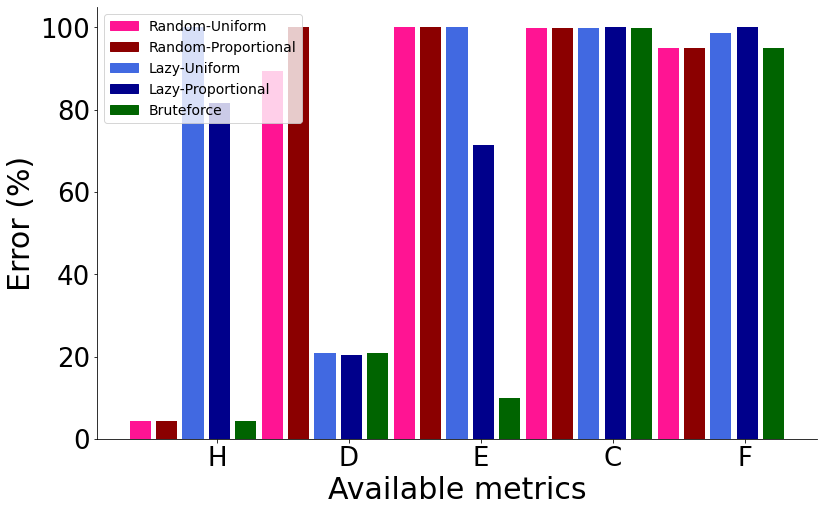

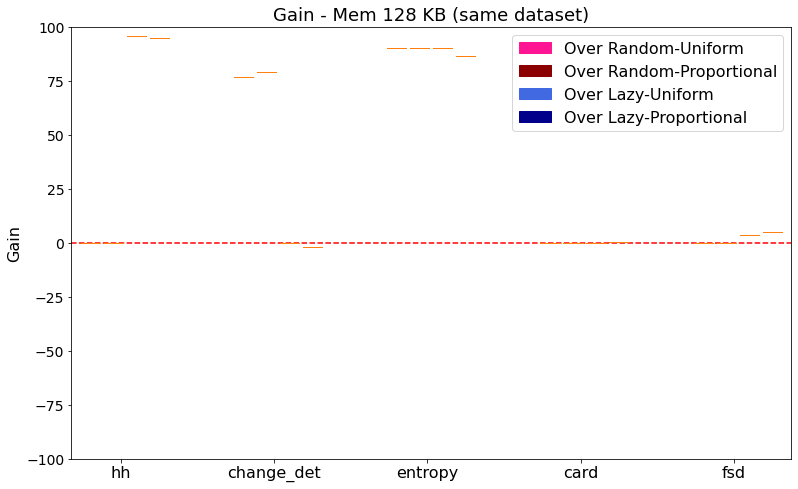

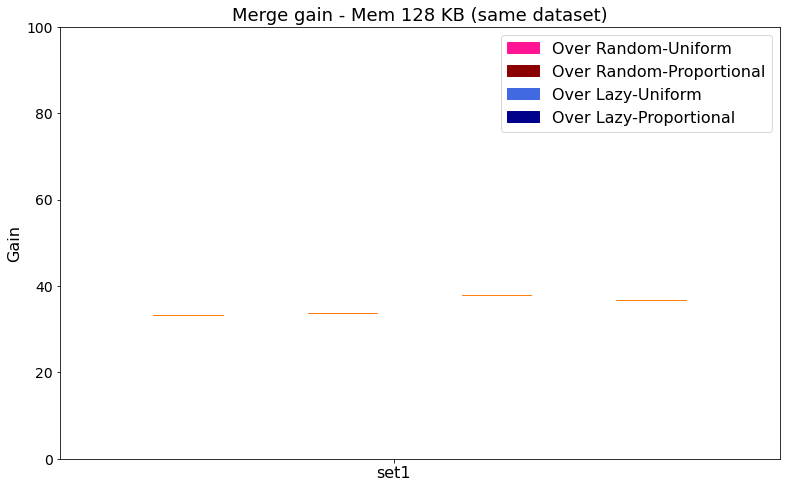

In [11]:
## pre-processing data
ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
## Get & record ensemble error
global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
## call plotting
call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

---

## Impact of memory sizes

In [42]:
## Plot raw result
def boxplot_impact_memory(data, labels, name, isSaveFig = False):
    ## comparison version plot
    # box plot 
    # https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
    # Box plots with custom fill colors
    # https://matplotlib.org/stable/gallery/statistics/boxplot_color.html

    import matplotlib.patches as mpatches

    xlabels = labels
    colors = ['deeppink', 'darkred', 'royalblue', 'darkblue']
    colors = colors * int(len(data) / 4) # 4 strawmen

    fig = plt.figure(figsize = (10, 6))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.set_ylim([0, 100])
    x_list = np.arange(0, len(data), 1, dtype=int)
    plot_list = []
    for d in data:
        plot_list.append(d[0])
    # Creating plot
    bplot = ax.bar(x_list, plot_list, color=colors)
    # bplot = ax.boxplot(x=data, 
    #                    positions = get_x_position(int(len(data) / 4), 4),
    #                    patch_artist=True) # , showfliers=False
    # ax.set_xlim(0, 1)

#     for patch, color in zip(bplot['boxes'], colors):
#         patch.set_facecolor(color)

    # plt.axhline(y = 0, color = 'r', linestyle = '--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.grid()
    
    plt.ylabel("Error reduction (%)", fontsize=28)
    plt.xlabel("Memory", fontsize=28)
    plt.xticks(get_xtick_position(int(len(data) / 4), 4), xlabels, fontsize=26)
    plt.yticks(fontsize=26)

    # plt.title(f"Impact of memory - {name}", fontsize=18)

    # create legends
    legend_labels = ['over Random-Uniform', 'over Random-Proportional', 
                    'over Lazy-Uniform', 'over Lazy-Proportional']
    legend_patch = []
    legend_patch.append(mpatches.Patch(color=colors[0], label=legend_labels[0]))
    legend_patch.append(mpatches.Patch(color=colors[1], label=legend_labels[1]))
    legend_patch.append(mpatches.Patch(color=colors[2], label=legend_labels[2]))
    legend_patch.append(mpatches.Patch(color=colors[3], label=legend_labels[3]))
    plt.legend(handles=legend_patch, fontsize=20, frameon=False, ncol=2) # , loc="upper right"

    # import pickle
    # with open(f'pickles/{name}.pkl', 'wb') as fout:
    #     pickle.dump(fig, fout)
    # plt.savefig('figures/impact_of_memory.pdf', format='pdf', bbox_inches='tight')

    # show plot
    plt.show()

In [43]:
name_for_all_taskset = []
for d in global_name_all_mem:
    tmp = d.split('(')[0].split('m ')[1]
    tmp = tmp.split(' ')[0]
    name_for_all_taskset.append(tmp)
name_for_all_taskset

['128']

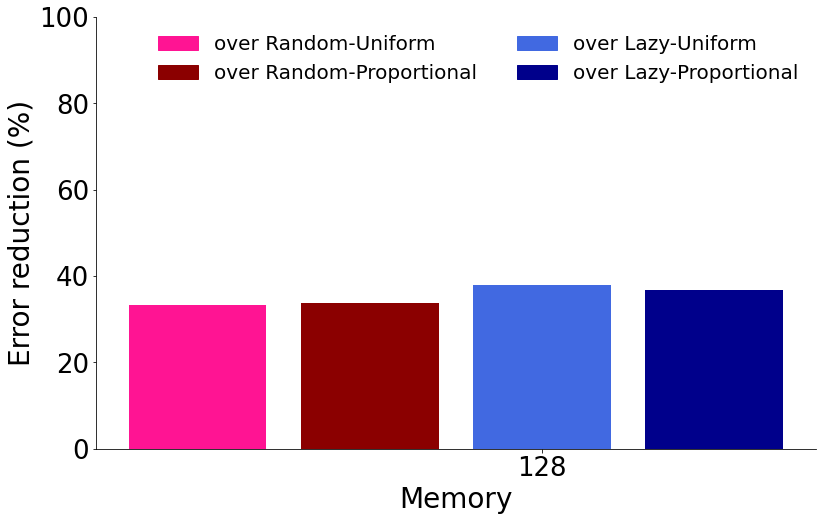

In [44]:
isSaveFig = False
boxplot_impact_memory(global_merge_gain_all_mem, name_for_all_taskset, "impact_of_memory", isSaveFig)

### Save plot data as json

In [15]:
# Save data as json
isDumpJson = False

if isDumpJson:
    # save gain result
    ll = []
    for arr in global_merge_gain_all_mem:
        ll.append(arr.tolist())
    with open('results/figure_data/impact_of_memory_gain.json', 'w') as out:
        json.dump(ll, out)
        
    # save ensemble error
    ll = []
    for arr in global_ensemble_error:
        ll.append(arr.tolist())
    with open('results/figure_data/impact_of_memory_error.json', 'w') as out:
        json.dump(ll, out)

In [45]:
global_ensemble_error

[array([77.72363896]),
 array([79.8352197]),
 array([83.85896356]),
 array([74.70128019]),
 array([45.97446243])]

In [46]:
global_merge_gain_all_mem

[array([33.36844598]),
 array([33.86075727]),
 array([37.89510738]),
 array([36.78908787])]